In [161]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os

In [2]:
initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')

In [3]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [4]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [5]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [6]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [7]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [8]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [9]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [165]:
grids_started = [
478, # for analysis of 131216001101084
1245,
1257,
1269,
1563,
1609,
1672,
1673,
1674,
1685,
1686,
1698,
1710,
]

In [166]:
grids_done = [
    1242,1243,1244,
    1254,1255,1256,
    1266,1267,1268,
    1351,1352,1353,1354,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,1390,
    1457,1458,1459,
    1460,
    1469,
    1470,1471,1472,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1506,1507,1508,
    1560,1561,1562,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1610,1611,
    1684,
    1695,1696,1697,
    1707,1708,1709,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,   
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,
    1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,
    1930,1931,1932,1933,
    1988,1989,
    1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_done),len(grids_done) * 280)

164 45920


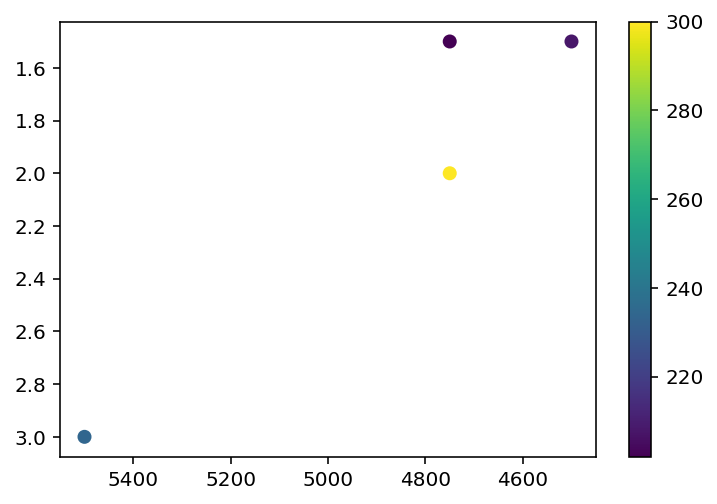

[1482, 1803, 1364, 1470]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1482,300,4750.0,4500.0,5000.0,2.0,1.5,2.5,-2.0,-2.5,-1.5,4570,4750_2.00_-2.00
1803,234,5500.0,5250.0,5750.0,3.0,2.5,3.5,-2.0,-2.5,-1.5,5330,5500_3.00_-2.00
1364,208,4500.0,4250.0,4750.0,1.5,1.0,2.0,-2.0,-2.5,-1.5,4315,4500_1.50_-2.00
1470,202,4750.0,4500.0,5000.0,1.5,1.0,2.0,-2.0,-2.5,-1.5,4565,4750_1.50_-2.00


In [167]:
selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
# selection = (priority['fe_h_subgrid'] > - 2) & (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200)
# selection = (priority['fe_h_subgrid'] <= -0.75) & (priority['counts_dr4_init'] > 2800)


f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

print(list(priority['index_subgrid'][selection]))

priority[selection]

In [168]:
# ALREADY DONE
selection = [
    1364,1365,
    1470,1471,
    1482, 1483,
    1598,
    1803,
    2002, 2001, 1919, 1918, 1931, 1920, 1845, 1930, 1833, 2014, 1844, 2003, 2013, 1932, 1832, 1834, 1846, 2015
]
selection = [1586,]# ] 1244, 1353, 1997, 2062, 1709, 2135

for t in selection:
    test_grid_index_computations(t)

In [169]:
all_around = np.unique([
])
all_around,len(all_around)

(array([], dtype=float64), 0)

In [171]:
grids_converted_to_nn_input = [
    1242,1243,1244,
    1254,1255,1256,
    1266,1267,1268,    
    1351,1352,1353,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,
    1390,
#     1457,
    1458,1459,
    1469,
    1470,1471,1472,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1560,1561,1562,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1695,1696,1697,
    1707,
#     1708,1709,1719,1720,1721,1790,1791,1792,1802,1803,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,
    1748,1749,
    1750,1751,1752,
    1819,1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,1930,1931,1932,1933,
    1988,1989,1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_converted_to_nn_input))

132


In [172]:
for s in [1470]:
    test_grid_index_ready_for_training(test_grid_index = s)
    # ready: 
    # 1482
    # 1832,1833,1834,
    # 1844,1845,1846,
    # 1918,1919,1920,
    # 1930,1931,1932,
    # 2001,2002,2003,
    # 2013,2014,2015

    # not ready: 1364 - missing 1457 which is running
    # not ready: 1470, missing 1457-1559, 1560-1562

1351 4500_1.00_-2.50  done
1352 4500_1.00_-2.00  done
1353 4500_1.00_-1.50  done
1363 4500_1.50_-2.50  done
1364 4500_1.50_-2.00  done
1365 4500_1.50_-1.50  done
1375 4500_2.00_-2.50  done
1376 4500_2.00_-2.00  done
1377 4500_2.00_-1.50  done
1457 4750_1.00_-2.50  not ready
1458 4750_1.00_-2.00  done
1459 4750_1.00_-1.50  done
1469 4750_1.50_-2.50  done
1470 4750_1.50_-2.00  done
1471 4750_1.50_-1.50  done
1481 4750_2.00_-2.50  done
1482 4750_2.00_-2.00  done
1483 4750_2.00_-1.50  done
1560 5000_1.00_-2.50  done
1561 5000_1.00_-2.00  done
1562 5000_1.00_-1.50  done
1572 5000_1.50_-2.50  done
1573 5000_1.50_-2.00  done
1574 5000_1.50_-1.50  done
1584 5000_2.00_-2.50  done
1585 5000_2.00_-2.00  done
1586 5000_2.00_-1.50  done


In [173]:
trained_3x3x3 = [
    1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    # could do 1832,1833,1834,
    # could do 1844,1845,1846,
    # could do 1918,1919,1920,
    # could do 1930,
    1931,
    # could do 1932,
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
# CURRENT GRID
#     2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
    # could do 2015,
]

print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Updating galah_dr4_model_trainingset_gridpoints_trained.fits!
Updated


In [174]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")

1354,
1457,
1460,
1506,
1507,
1508,
1610,
1611,
1684,
1708,
1709,
1719,
1720,
1721,
1790,
1791,
1792,
1802,
1803,
1804,
1814,
1815,
1816,
1876,
1877,
1878,
1888,
1889,
1890,
1900,
1901,
1902,
32
import os
ps = [1354,1457,1460,1506,1507,1508,1610,1611,1684,1708,1709,1719,1720,1721,1790,1791,1792,1802,1803,1804,1814,1815,1816,1876,1877,1878,1888,1889,1890,1900,1901,1902]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))


In [175]:
# Currently converting
# t1: 1708,1709,1719,1720,1721,1790,1791,1792,1802,1803
# t2: 1804,1814,1815,1816,1876,1877,1878,1888,1889,1890,1900,1901,1902

In [176]:
print(len(np.unique(list(progress_table['next_calculation'][np.where((progress_table['grids_calculated'] >= 6) & (progress_table['trainingset_done'] != 1))[0]]))))
np.unique(list(progress_table['next_calculation'][np.where((progress_table['grids_calculated'] >= 6) & (progress_table['trainingset_done'] != 1))[0]]))

55


array([   0, 1133, 1340, 1341, 1362, 1374, 1447, 1473, 1480, 1485, 1497,
       1609, 1638, 1639, 1640, 1650, 1651, 1652, 1672, 1673, 1684, 1685,
       1710, 1779, 1801, 1805, 1808, 1809, 1810, 1827, 1830, 1836, 1842,
       1848, 1894, 1895, 1896, 1916, 1922, 1928, 1934, 1972, 1977, 1978,
       1979, 1999, 2005, 2011, 2017, 2151, 2152, 2153, 2163, 2164, 2165])

In [177]:
progress_table[np.where((progress_table['grids_calculated'] == 7) & (progress_table['trainingset_done'] != 1))[0]]

index_subgrid,trainingset_done,grids_trainingset,grids_calculated,next_conversion,next_calculation,grid_1,grid_2,grid_3,grid_4,grid_5,grid_6,grid_7,grid_1_calculated,grid_2_calculated,grid_3_calculated,grid_4_calculated,grid_5_calculated,grid_6_calculated,grid_7_calculated,grid_1_trainingset,grid_2_trainingset,grid_3_trainingset,grid_4_trainingset,grid_5_trainingset,grid_6_trainingset,grid_7_trainingset
int64,int64,float64,float64,int64,int64,str15,str15,str15,str16,str15,str15,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1364,0,7.0,7.0,0,0,4500_1.50_-2.00,4250_1.50_-2.00,4750_1.50_-2.00,4500_1.00_-2.00,4500_2.00_-2.00,4500_1.50_-2.50,4500_1.50_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1365,0,7.0,7.0,0,0,4500_1.50_-1.50,4250_1.50_-1.50,4750_1.50_-1.50,4500_1.00_-1.50,4500_2.00_-1.50,4500_1.50_-2.00,4500_1.50_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1376,0,7.0,7.0,0,0,4500_2.00_-2.00,4250_2.00_-2.00,4750_2.00_-2.00,4500_1.50_-2.00,4500_2.50_-2.00,4500_2.00_-2.50,4500_2.00_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1377,0,7.0,7.0,0,0,4500_2.00_-1.50,4250_2.00_-1.50,4750_2.00_-1.50,4500_1.50_-1.50,4500_2.50_-1.50,4500_2.00_-2.00,4500_2.00_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1470,0,7.0,7.0,0,0,4750_1.50_-2.00,4500_1.50_-2.00,5000_1.50_-2.00,4750_1.00_-2.00,4750_2.00_-2.00,4750_1.50_-2.50,4750_1.50_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1471,0,7.0,7.0,0,0,4750_1.50_-1.50,4500_1.50_-1.50,5000_1.50_-1.50,4750_1.00_-1.50,4750_2.00_-1.50,4750_1.50_-2.00,4750_1.50_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1483,0,7.0,7.0,0,0,4750_2.00_-1.50,4500_2.00_-1.50,5000_2.00_-1.50,4750_1.50_-1.50,4750_2.50_-1.50,4750_2.00_-2.00,4750_2.00_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1494,0,6.0,7.0,1506,0,4750_2.50_-2.00,4500_2.50_-2.00,5000_2.50_-2.00,4750_2.00_-2.00,4750_3.00_-2.00,4750_2.50_-2.50,4750_2.50_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1495,0,6.0,7.0,1507,0,4750_2.50_-1.50,4500_2.50_-1.50,5000_2.50_-1.50,4750_2.00_-1.50,4750_3.00_-1.50,4750_2.50_-2.00,4750_2.50_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [178]:
upcoming_priority = priority[[x not in trained_3x3x3 for x in priority['index_subgrid']]]
upcoming_priority[0]

index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1499,30238,4750.0,4500.0,5000.0,2.5,2.0,3.0,-0.25,-0.5,0.0,4750,4750_2.50_-0.25


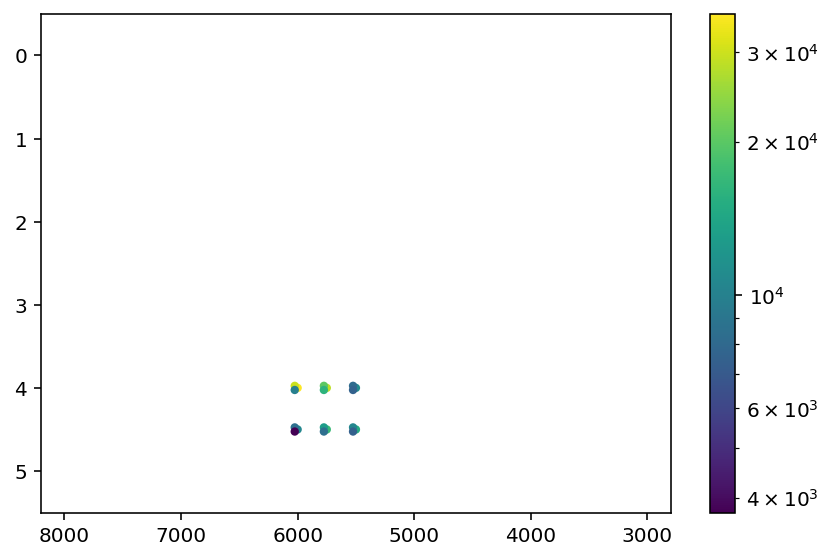

[2002, 2001, 1919, 1918, 1931, 1920, 1845, 1930, 1833, 2014, 1844, 2003, 2013, 1932, 1832, 1834, 1846, 2015]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
2002,35637,6000.0,5750.0,6250.0,4.0,3.5,4.5,0.0,-0.25,0.25,6040,6000_4.00_0.00
2001,29806,6000.0,5750.0,6250.0,4.0,3.5,4.5,-0.25,-0.5,0.0,6015,6000_4.00_-0.25
1919,28433,5750.0,5500.0,6000.0,4.0,3.5,4.5,0.0,-0.25,0.25,5790,5750_4.00_0.00
1918,20179,5750.0,5500.0,6000.0,4.0,3.5,4.5,-0.25,-0.5,0.0,5765,5750_4.00_-0.25
1931,17142,5750.0,5500.0,6000.0,4.5,4.0,5.0,0.0,-0.25,0.25,5795,5750_4.50_0.00
1920,16039,5750.0,5500.0,6000.0,4.0,3.5,4.5,0.25,0.0,0.5,5815,5750_4.00_0.25
1845,15012,5500.0,5250.0,5750.0,4.5,4.0,5.0,0.0,-0.25,0.25,5545,5500_4.50_0.00
1930,13000,5750.0,5500.0,6000.0,4.5,4.0,5.0,-0.25,-0.5,0.0,5770,5750_4.50_-0.25
1833,11056,5500.0,5250.0,5750.0,4.0,3.5,4.5,0.0,-0.25,0.25,5540,5500_4.00_0.00


In [179]:
# selection = (priority['counts_dr4_init'] > 10000)# & (priority['fe_h_subgrid'] < -0.5)
selection = (
    (priority['teff_subgrid'] >= 5500) &
    (priority['teff_subgrid'] <= 6000) &
    (priority['logg_subgrid'] >= 4.0) &
    (priority['logg_subgrid'] <= 5.0) &
    (priority['fe_h_subgrid'] >= -0.25) &
    (priority['fe_h_subgrid'] <= 0.25)
)

f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
    priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
    s = 10,
    norm=LogNorm()
)
ax.set_xlim(8200,2800)
ax.set_ylim(5.5,-0.5)
plt.colorbar(s, ax=ax)
plt.tight_layout()
plt.show()
plt.close()
print(list(priority['index_subgrid'][selection]))
priority[selection]